# Tweets sentimental analysis using Machine Learning

#### Importing the neccessary packages

In [37]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import f1_score,accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from time import process_time
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import pickle

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re, string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\HP
[nltk_data]     India\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\HP
[nltk_data]     India\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\HP
[nltk_data]     India\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
# Importing the datasets
df = pd.read_csv('twitter_data.csv',encoding='Latin-1',names=["sentiment","id","date","flag","user","tweet"])

## Exploratory Data Analysis

In [39]:
df.head(10)

,sentiment,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [40]:
df.shape

(1600000, 6)

In [41]:
# Checking for null values in the datasets
print(df.isnull().values.any())


#In case of null value we will fill the null values with mean: 
def dataImputation(data,key):
    data = data.fillna(data[key].mean())
    return data;

False


#### As we can see there aren't any null values in both the datasets, now we shall see the total number of entries in each dataset.

In [42]:
# We need only tweets and sentiments
df = df[['sentiment','tweet']]

In [43]:
df.head(5)

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [44]:
df = df.sample(100000) #Size issue

In [45]:
df.shape

(100000, 2)

In [46]:
df.head()

,sentiment,tweet
1588258,4,"@jen101 yeah, 38. i think i am 2 doors down fr..."
1393805,4,hanging out with my cousins for a night is goo...
553655,0,@wtcc on the website it says &quot;Available J...
1249180,4,@jordanklicious http://twitpic.com/6fb41 - Gee...
1307085,4,babysitting Gracie and Nora tomorrow Learned ...


In [47]:
df.describe()

,sentiment
count,100000.000000
mean,2.004880
std,2.000004
min,0.000000
25%,0.000000
50%,4.000000
75%,4.000000
max,4.000000


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1588258 to 804919
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  100000 non-null  int64 
 1   tweet      100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


The number of good tweets in the dataset is: 50122
The number of bad tweets in the dataset is: 49878


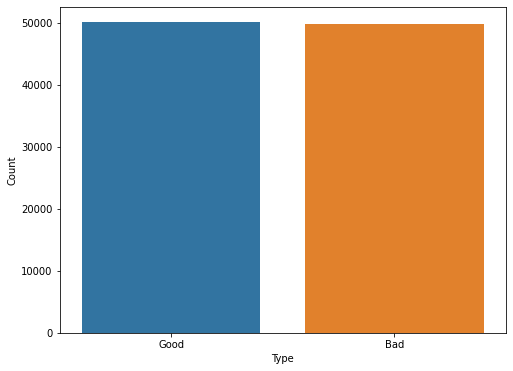

In [49]:
# Visualising our data

figure(figsize=(8, 6))
print(f"The number of good tweets in the dataset is: {df['sentiment'].where(df['sentiment'] == 4).count()}")
print(f"The number of bad tweets in the dataset is: {df['sentiment'].where(df['sentiment'] == 0).count()}")
plot = sns.barplot(x = ['Good', 'Bad'], y = df['sentiment'].value_counts())
plot.set(xlabel='Type', ylabel='Count')
plt.show();

## Data Preprocessing
We have now succesfully merged our datasets and got one unified one, we can see that our independent feature is the name of the URL, that opens a lot of ways to deal with as an NLP task. 

In [50]:
#Data cleaning (removing username,links and punctuation )
def clean_text(text):
    # miniscule
    text = text.lower()
    
    # removing usernames
    text = re.sub('@[^\s]+', '', text)

    # removing links
    text = re.sub('((https?://[^\s]+)|(www\.[^\s]+))','',text)
    
    # removing punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    
    # tokenization
    tokens = word_tokenize(text)
    final_words = []
    for token in tokens:
        final_words.append(token)
    return ' '.join(final_words)

In [51]:
start = process_time()
print('Starting the pre-processing.....')
df['cleaned_text'] = df['tweet'].apply(lambda x: clean_text(x))
end = process_time()
print(f'Process Finished! and took {end - start}s')
df.head()

Starting the pre-processing.....
Process Finished! and took 96.765625s


,sentiment,tweet,cleaned_text
1588258,4,"@jen101 yeah, 38. i think i am 2 doors down fr...",yeah 38 i think i am 2 doors down from ya
1393805,4,hanging out with my cousins for a night is goo...,hanging out with my cousins for a night is goo...
553655,0,@wtcc on the website it says &quot;Available J...,on the website it says quotavailable june 18th...
1249180,4,@jordanklicious http://twitpic.com/6fb41 - Gee...,geeeez those dimples are working overtime in t...
1307085,4,babysitting Gracie and Nora tomorrow Learned ...,babysitting gracie and nora tomorrow learned m...


In [52]:
df.shape

(100000, 3)

We can see that the number of Good URLs is far more than Bad URLs in our dataset and that makes our data <b>imbalanced</b> we can try resampling to solve this particular issue.

In [53]:
good_tweets = df[df['sentiment'] == 4]
bad_tweets =  df[df['sentiment'] == 0]

In [54]:
good_tweets.head(10)

,sentiment,tweet,cleaned_text
1588258,4,"@jen101 yeah, 38. i think i am 2 doors down fr...",yeah 38 i think i am 2 doors down from ya
1393805,4,hanging out with my cousins for a night is goo...,hanging out with my cousins for a night is goo...
1249180,4,@jordanklicious http://twitpic.com/6fb41 - Gee...,geeeez those dimples are working overtime in t...
1307085,4,babysitting Gracie and Nora tomorrow Learned ...,babysitting gracie and nora tomorrow learned m...
1472404,4,is tired. &amp; wants to go to sleep na. let's...,is tired amp wants to go to sleep na lets call...
852923,4,@claudia10 it is the rite of passage for some.,it is the rite of passage for some
1101877,4,@Nurul54 @MATT_369 @starlingpoet @ChandraLee @...,i appreciate all the ff luv you guys rock
1284700,4,@AvatarOne - that's a good look. Do it justice...,thats a good look do it justice theres a good boy
1450661,4,@gregorymyricks Get 100 followers a day using ...,get 100 followers a day using once you add eve...
1349301,4,@JazzyTeeSings good luck,good luck


Process Finished! and took 24.703125s


Text(0.5, 1.0, 'Tweets positifs')

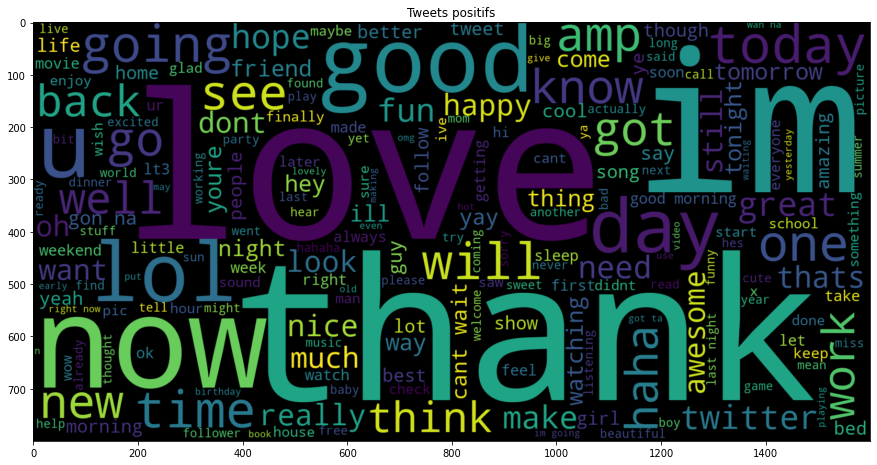

In [20]:
plt.figure(figsize = (15,15)) 
start = process_time()
wc = WordCloud(max_words = 200 , width = 1600 , height = 800).generate(" ".join(good_tweets.cleaned_text))
end = process_time()
print(f'Process Finished! and took {end - start}s')
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Positive tweets')

In [55]:
bad_tweets.head(10)

,sentiment,tweet,cleaned_text
553655,0,@wtcc on the website it says &quot;Available J...,on the website it says quotavailable june 18th...
584452,0,watchin House of Payne now....... then i'm gon...,watchin house of payne now then im gon na watc...
30183,0,@zackalltimelow i SO need u in Brazil!,i so need u in brazil
262467,0,@malapropisms still packing... Then shower. Th...,still packing then shower then maybe but i hav...
778914,0,@snobiwan Yr makinâ me hungry Thereâs no ...,yr makinâ me hungry thereâs no food in the...
676687,0,"@magnifikka no more.. Oh yes, the giant spoon ...",no more oh yes the giant spoon and fork more g...
242943,0,Is Sad That Matthew Is Moving To New York!!!,is sad that matthew is moving to new york
578333,0,i miss dry gulch... and pastor roy! and the ot...,i miss dry gulch and pastor roy and the other ...
611549,0,"@kaboogie okay, i'll stop calling you, have a ...",okay ill stop calling you have a happy birthda...
373186,0,big day tomorrow....test time! wish me luck,big day tomorrowtest time wish me luck


Process Finished! and took 24.40625s


Text(0.5, 1.0, 'Negetive tweets')

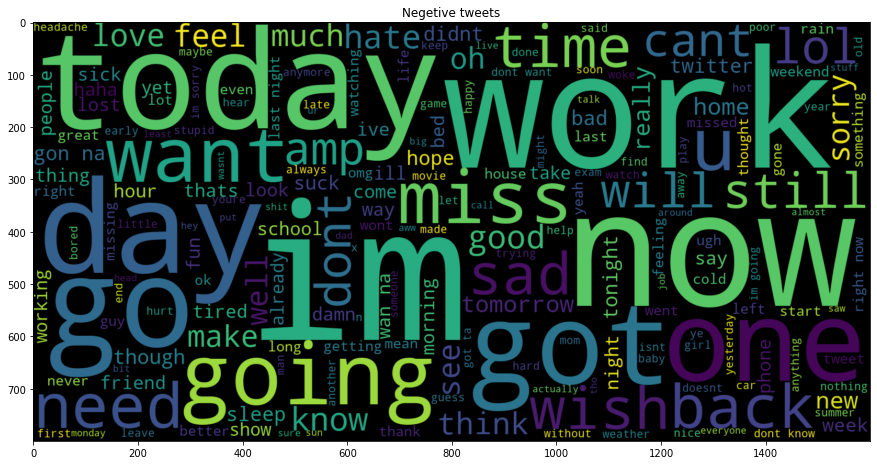

In [22]:
plt.figure(figsize = (15,15)) 
start = process_time()
wc = WordCloud(max_words = 200 , width = 1600 , height = 800).generate(" ".join(bad_tweets.cleaned_text))
end = process_time()
print(f'Process Finished! and took {end - start}s')
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Negetive tweets')

In [ ]:
# df.head(5)

#### Taking a quick look at the sample of our dataset we can see there are a lot of redundant things in our URL like '/ ',  ' : ',  ' . ', etc. these symbols are not neccessary for us. Further in the project we will be using TD-IDF Vectorizer to give scores to these tweets based on their lexical features. It will be a good if we will extract these words from the tweet and remove all the redundant characters from it.


<ul>
<li>To do this operation we used Regexp Tokenizer. What it does is that it splits the string using a regular express that we pass and we get the list of words that we need for our analysis. </li>
    <li>According to the documentation: "A <b>RegexpTokenizer</b> splits a string into substrings using a regular expression."
    </ul>

In [56]:
tknizer = RegexpTokenizer(r'[A-Za-z]+')

In [57]:
#Testing on a random URL
tknizer.tokenize('http://localhost:8888/notebooks/tweet%20analysis%20using%20Python.ipynb')

['http',
 'localhost',
 'notebooks',
 'tweet',
 'analysis',
 'using',
 'Python',
 'ipynb']

Defining a small function to form a new column in our dataframe that contains the tokenized tweets 

In [58]:
def tokenizeUrl(url):
    return tknizer.tokenize(url)

start = process_time()
print('Starting the process to tokenize the tweets...')

# Creating a new column in our dataframe that keeps the tokenized form of the URLs
df['tokenized_tweet'] = df.cleaned_text.map(tokenizeUrl)
end = process_time()
print(f'Process Finished! and took {end - start}s')

Starting the process to tokenize the tweets...
Process Finished! and took 2.5s


In [59]:
df.head(5)

,sentiment,tweet,cleaned_text,tokenized_tweet
1588258,4,"@jen101 yeah, 38. i think i am 2 doors down fr...",yeah 38 i think i am 2 doors down from ya,"[yeah, i, think, i, am, doors, down, from, ya]"
1393805,4,hanging out with my cousins for a night is goo...,hanging out with my cousins for a night is goo...,"[hanging, out, with, my, cousins, for, a, nigh..."
553655,0,@wtcc on the website it says &quot;Available J...,on the website it says quotavailable june 18th...,"[on, the, website, it, says, quotavailable, ju..."
1249180,4,@jordanklicious http://twitpic.com/6fb41 - Gee...,geeeez those dimples are working overtime in t...,"[geeeez, those, dimples, are, working, overtim..."
1307085,4,babysitting Gracie and Nora tomorrow Learned ...,babysitting gracie and nora tomorrow learned m...,"[babysitting, gracie, and, nora, tomorrow, lea..."


We only need the words of the URL not the commas that are seperating them in the list so we will define a function that removes the commas and append that as a new column 
in our Dataframe.

In [60]:
def clean_token(token):
    return ' '.join(token);
df['tokenized_tweet_cleaned'] = df['tokenized_tweet'].map(clean_token)

In [61]:
print(df.shape)
df.sample(10)

(100000, 5)


,sentiment,tweet,cleaned_text,tokenized_tweet,tokenized_tweet_cleaned
68289,0,"@RyanSeacrest so very sad, thinking of the co...",so very sad thinking of the cook family,"[so, very, sad, thinking, of, the, cook, family]",so very sad thinking of the cook family
228992,0,@lucasd this weather makes me into a whiny bit...,this weather makes me into a whiny bitchalso i...,"[this, weather, makes, me, into, a, whiny, bit...",this weather makes me into a whiny bitchalso i...
398618,0,@SashaPanda oooooooh.... hope you'll be bett...,oooooooh hope youll be better soon,"[oooooooh, hope, youll, be, better, soon]",oooooooh hope youll be better soon
671435,0,Technical Problems On GotSaga MM?? @PatriciaVa...,technical problems on gotsaga mm my saga have ...,"[technical, problems, on, gotsaga, mm, my, sag...",technical problems on gotsaga mm my saga have ...
355331,0,@MexicanHatBoy Can't believe the Tories have s...,cant believe the tories have so many areas und...,"[cant, believe, the, tories, have, so, many, a...",cant believe the tories have so many areas und...
434833,0,"@samwilliamh bah, and i still gotta finish som...",bah and i still got ta finish some work for to...,"[bah, and, i, still, got, ta, finish, some, wo...",bah and i still got ta finish some work for to...
657757,0,"@kirstiealley Hey Kirstie Hi from the UK, sadl...",hey kirstie hi from the uk sadly our summer ha...,"[hey, kirstie, hi, from, the, uk, sadly, our, ...",hey kirstie hi from the uk sadly our summer ha...
746113,0,@anthonysd After Brazil slaughtered them I cou...,after brazil slaughtered them i counted them o...,"[after, brazil, slaughtered, them, i, counted,...",after brazil slaughtered them i counted them o...
172737,0,@MashUpNicole I still have an hour.,i still have an hour,"[i, still, have, an, hour]",i still have an hour
1438996,4,@ajaymohanreddy Eager to hear from your end on...,eager to hear from your end on the dandeli fro...,"[eager, to, hear, from, your, end, on, the, da...",eager to hear from your end on the dandeli fro...


## TF-IDF Vectorizer
We are using TF-IDF algorithm to transform our tokenized_tweets into numerical representation that we further use in our Machine learning algorithm to make predictions. 

<br>

<b> What does TF-IDF vectorizer do? </b>


<br>
What it does is that it first calculates the term frequency i.e.
    
<br><b>Term Frequency</b>:  (Number of repetions of particular word in sentence)/(Number of words in sentence)

<br>
Then it calculates the Inverse document frequency i.e.

<br><b>IDF:</b> log((No. of sentences)/(No. of sentences containing that word))

<br> In the final step it multiplies TF and IDF and assigns that value to the word
    

In [68]:
vectorizer = TfidfVectorizer();

start = process_time()
print('Vectorizing tweets...')
tweet_names = vectorizer.fit_transform(df.tokenized_tweet_cleaned)
end = process_time()
print(f'Task Complete! and took {end - start}s')

Vectorizing tweets...
Task Complete! and took 7.203125s


In [71]:
print(tweet_names)

  (0, 62950)	0.38830220971656365
  (0, 19946)	0.2779581432221488
  (0, 14920)	0.3478377016093713
  (0, 14794)	0.6097618535735803
  (0, 1645)	0.2765869709731793
  (0, 55288)	0.2965951075741878
  (0, 63145)	0.33866069961288486
  (1, 20142)	0.33026525184605177
  (1, 21566)	0.25249110718615697
  (1, 26957)	0.19154085031748236
  (1, 36818)	0.304320178067566
  (1, 19333)	0.1983035307571319
  (1, 11610)	0.5314468290287694
  (1, 35812)	0.17593009781178537
  (1, 61917)	0.23692235493251676
  (1, 39061)	0.26019322011722507
  (1, 23121)	0.4704575435916295
  (2, 59118)	0.23008126711812632
  (2, 28956)	0.38491889158478554
  (2, 55066)	0.25264975232398595
  (2, 55482)	0.47548324984563967
  (2, 28264)	0.28339934126764155
  (2, 43279)	0.47548324984563967
  (2, 47878)	0.2661378747627528
  (2, 27066)	0.12280916710139138
  :	:
  (99998, 41356)	0.3629034303630431
  (99998, 17879)	0.3363750052555767
  (99998, 56741)	0.29308816923598585
  (99998, 14541)	0.27524415913737743
  (99998, 11813)	0.3047595766297975

### Splitting the data for training and testing

In [72]:
trainX, testX, trainY, testY = train_test_split(tweet_names, df.sentiment)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
print(df.shape)

(75000, 64073)
(75000,)
(25000, 64073)
(25000,)
(100000, 5)


# MODELLING

## 1. Logistic Regression
The first classification algorithm we used is <b>Logistic Regression</b>
<br>
We will be using two algorithms on this data and will deploy our model with the better performing one.

In [73]:
logreg = LogisticRegression(max_iter=600)

In [74]:
print('********************************************************')
print('Applying Logistic Regression...')
start = process_time()
logreg.fit(trainX, trainY)
end = process_time()
print(f'Model is trained. It took {end - start} seconds to train the model!')
print('********************************************************')

********************************************************
Applying Logistic Regression...
Model is trained. It took 5.15625 seconds to train the model!
********************************************************


In [75]:
print(f'The model has a {logreg.score(trainX, trainY) * 100:.2f}% Training accuracy')
print(f'The model has a {logreg.score(testX, testY) * 100:.2f}% Testing accuracy')
# Appending the logistic regression model score to our list
# model_scores.append(logreg.score(testX, testY))

The model has a 83.40% Training accuracy
The model has a 77.96% Testing accuracy


### Confusion Matrix for Logistic Regression
Using the confusion matrix we can visualise that how accurate our model is

Classification Matrix for the model is: 



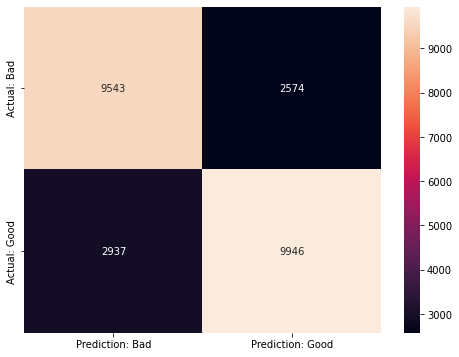

In [76]:
conf_mat = pd.DataFrame(confusion_matrix(logreg.predict(testX), testY), columns = ['Prediction: Bad', 'Prediction: Good'], index = ['Actual: Bad', 'Actual: Good'])
print('Classification Matrix for the model is: \n')
figure(figsize = (8, 6))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.show();

## 2. Random Forest
The Second classification algorithm we used is <b>Random Forest</b>
<br>

In [77]:
rf = RandomForestClassifier(n_estimators=1,max_depth=2,random_state=0)

In [78]:
print('********************************************************')
print('Applying Random forest algorithm ...')
start = process_time()
rf.fit(trainX, trainY)
end = process_time()
print(f'Model is trained. It took {end - start} seconds to train the model!')
print('********************************************************')

********************************************************
Applying Random forest algorithm ...
Model is trained. It took 0.328125 seconds to train the model!
********************************************************


In [79]:
score = rf.score(trainX,trainY)
print(score)

0.5018533333333334


In [80]:
score = rf.score(testX,testY)
print(score)

0.50112


### We implemented our random forest with  estimator trees . It may be not the max accuracy , So we will iterate for 2-5 estimators and check for maximum 
#### Because of heavy data we can't take more estimator trees as it will take huge time 

In [108]:
# this will take 1 min atleast

acc_lst = []
start = process_time()
# for i in range(1,50):
acc = cross_val_score(RandomForestClassifier(n_estimators=100,max_depth=2,criterion='entropy'),trainX,trainY,cv=5).mean()
end = process_time()
print(f'Process Finished! and took {end - start}s')
print(acc)
#     acc_lst.append(acc)

Process Finished! and took 58.859375s
0.6408933333333333


In [109]:
# print(acc_lst)
# plt.plot(acc_lst)
# mx = np.argmax(acc_lst)
# plt.show()

### If we calculate this for 20-30 estimator tree tree will be more randomised and we will choose the point where it gave maximum accuracy 

In [119]:
# We got the maximum n_estimator point now (:
# print(mx)
rf = RandomForestClassifier(n_estimators = 2,max_depth=3,criterion='entropy')
rf.fit(trainX,trainY)

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=2)

In [110]:
print(f'The model has a {rf.score(trainX,trainY) * 100:.2f}% Training accuracy')
print(f'The model has a {rf.score(testX,testY) * 100:.2f}% Testing accuracy')

The model has a 50.25% Training accuracy
The model has a 50.50% Testing accuracy


## 2. Naive Bayes Classifier
The Second classification algorithm we used is <b>Naive Bayes Classifier</b>
<br>

In [82]:
nb = MultinomialNB()
start_time = process_time()
nb.fit(trainX,trainY)
start_time = process_time()
print(f'Process Finished! and took {end - start}s')
# print("Execution Time:", time.time()-start_time,"secs")

Process Finished! and took 0.328125s


In [83]:
y_pred_nb = nb.predict(testX)
print("Accuracy:\n", accuracy_score(testY, y_pred_nb))

Accuracy:
 0.75492


### We can see that Logistic Regression performs better than Random Forest Classfier on our dataset so we will dump our model as pickel file

In [84]:
pipeline_logreg = make_pipeline(TfidfVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize), LogisticRegression(max_iter=600))

In [86]:
trainX, testX, trainY, testY = train_test_split(df.tweet, df.sentiment)

In [87]:
print('*******************************************')
print('Training...')
pipeline_logreg.fit(trainX,trainY)
print('Process Finished')
print('*******************************************')

*******************************************
Training...
Process Finished
*******************************************


In [88]:
print(f'The accuracy is: {pipeline_logreg.score(testX, testY)}')

The accuracy is: 0.78608


In [89]:
pickle.dump(pipeline_logreg,open('logreg.pkl','wb'))

In [90]:
loaded_logreg = pickle.load(open('logreg.pkl', 'rb'))
res = loaded_logreg.score(testX, testY)
print(res)

0.78608


In [108]:
# 0 means negetive 
# 1 means positive
url = ['i am ugly']
res = loaded_logreg.predict(url)
print(res)

[0]


In [96]:
url = ['my friends are awesome']
res = loaded_logreg.predict(url)
print(res)

[0]
